Data Processing - Steric Paper - Part 2 

4. Create ENS and group means
5. Compute global time series
4. Compute trends with Hector (this is continued in separated scripts)


In [1]:
import os
import sys
sys.path.append("/Users/ccamargo/Documents/py_scripts/")
import utils_SL as sl 
import xarray as xr
import numpy as np


def get_filelist_sufix(path,  #'/Volumes/ccamargo/Data/'
                 sufix='', #'*grb'
                 sort=True
                 ):
    flist=[filename for filename in os.listdir(path) 
    if filename.endswith(sufix)]
    if sort:
        flist=sorted(flist) # Force it to be in the right order
    
    return flist


import cmocean as cmo
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import pandas as pd

In [2]:
import datetime as dt
from netCDF4 import Dataset
def write_nc(value,lati=[0],long=[0],tempo=[0],dep=[0],dim=3,
             #path='/Users/',fname='file',
             time_un='months since 1993-01-01',
             time_span='from 1993.01 to 2017.12',
             data_name='sea_level_height',data_un='M',
             data_missing='nan',
             data_depth='surface: 0m',
             depth_info='0 to 2000m',
             data_source='source',
             data_metadata='Data regridded to 132x360, and applied land mask based on ETOPO1',
             comp_date='made on this date',
             kurs='/Users/ccamargo/Desktop/filename.nc'):

             
    ncfile = Dataset(kurs,'w',format='NETCDF4_CLASSIC')
    
    # create Dimension
    lat_dim = ncfile.createDimension('lat', len(lati)) # latitude axis
    # Create Variable
    lat = ncfile.createVariable('lat', np.float32, ('lat',))
    lat.units = 'degrees_north'
    lat.long_name = 'latitude'
    # Add data to variable
    lat[:] = lati
    
    lon_dim = ncfile.createDimension('lon', len(long)) # latitude axis
    lon = ncfile.createVariable('lon', np.float32, ('lon',))
    lon.units = 'degrees_east'
    lon.long_name = 'longitude'
    lon[:]=long
    
    
    
    time_dim = ncfile.createDimension('time',len(tempo)) # time axis
    time = ncfile.createVariable('time', np.float32, ('time',))
    time.units = time_un
    time.long_name = 'time'
    time[:]=tempo
    
    
    ## 
    s=value.shape
    
    data = ncfile.createVariable('data',np.float64,('time','lat','lon'))
    data[:,:,:]=value
    
    data.units=data_un
    data.standard_name=data_name
    data.depth=data_depth
    data.missing=data_missing
    
    ncfile.metadata=data_metadata
    ncfile.depth_info=depth_info
    ncfile.timespan=time_span
    ncfile.source=data_source
    ncfile.comp_date=comp_date
    
    # close file
    ncfile.close();

# 4. Create ENS and group means

In [3]:
path_to_2005_2015='/Users/ccamargo/Desktop/paper1/steric/data/final/2005-2015/regional/'
path_to_1993_2017='/Users/ccamargo/Desktop/paper1/steric/data/final/1993-2017/regional/'

## 2005-2015

In [5]:
filenames=get_filelist_sufix(path_to_2005_2015,sufix='.nc')
pwd=path_to_2005_2015

# get dimensions
file=filenames[0]
ds=xr.open_dataset(pwd+file,decode_times=False)
lat=np.array(ds.lat)
lon=np.array(ds.lon)

time=np.array(ds.time)
delt=1296000000000
ty=pd.date_range(start='1/1/2005', periods=len(time),freq='M')
tim = np.array(ty.to_pydatetime(), dtype=np.datetime64)
time=tim-delt
tdec,tdec0=sl.get_dec_time(time,ns=1e-6)

# make empty arrays:
data=np.zeros((len(filenames)+4,len(time),len(lat),len(lon)))
datamu=np.zeros((len(filenames)+4,len(time),len(lat),len(lon)))
data.fill('nan')
datamu.fill('nan')

# Open each dataset and get the steric height at surface
for i,file in enumerate(filenames):
    ds=xr.open_dataset(pwd+file,decode_times=False)
    data[i,:,:,:]=np.array(ds.data)
    mu=np.nanmean(data[i,:,:,:],axis=0) # take time mean
    datamu[i,:,:,:]=np.array(data[i,:,:,:]-mu) # remove mean of the time series so that they are all around zero
    

#datasets name based on flist
fname=['APDRC','SIORG','Armor3D','BOA','CGlors','CORA','C17','EN4','FOAM','GLORYS','ISAS','ISAS+','IK09','ORAS','SODA']
group=['argo','argo','mis','argo','rea','mis','mis','mis','rea','rea','argo','mis','mis','rea','rea']

# Make a data array with the individual datasets:
da=xr.Dataset(data_vars={'data':(('name','time','lat','lon'),data[0:(i+1),:,:,:]),
                        'datamu':(('name','time','lat','lon'),datamu[0:(i+1),:,:,:])},
                         coords={'name':fname,
                                 'group':group,
                                 'time':time,
                                 'tdec':tdec,
                                 'lat':lat,
                                 'lon':lon})


# Create ENS and GROUP Means (15 +4 datasets)
fname2=[None]*len(data)
fname2[0:15]=fname

# Create group means:
i=i+1
fname2[i]='ARGO'
da2=da.where((da.name=='APDRC')|(da.name=='SIORG')|(da.name=='BOA')|(da.name=='ISAS'),drop=True)
datamu[i,:,:,:]=da2.datamu.mean(dim='name')
data[i,:,:,:]=da2.data.mean(dim='name')

i=i+1
fname2[i]='MiS'
da2=da.where((da.name=='Armor3D')|(da.name=='CORA')|(da.name=='C17')|(da.name=='IK09')|(da.name=='ISAS+')|(da.name=='EN4'),drop=True)
datamu[i,:,:,:]=da2.datamu.mean(dim='name')
data[i,:,:,:]=da2.data.mean(dim='name')

i=i+1
fname2[i]='REA'
da2=da.where((da.name=='CGlors')|(da.name=='GLORYS')|(da.name=='FOAM')|(da.name=='ORAS')|(da.name=='SODA'),drop=True)
datamu[i,:,:,:]=da2.datamu.mean(dim='name')
data[i,:,:,:]=da2.data.mean(dim='name')

#create ENS mean based on the datamu:
i=i+1
datamu[i,:,:,:]=np.array(da.datamu.mean(dim='name'))
data[i,:,:,:]=np.array(da.data.mean(dim='name'))
fname2[i]='ENS'
             

# Create final dataset
da=xr.Dataset(data_vars={'data':(('fname','time','lat','lon'),data),
                        'datamu':(('fname','time','lat','lon'),datamu)},
                         coords={'fname':fname2[0:19],
                                 'time':time,
                                 'tdec':tdec,
                                 'lat':lat,
                                 'lon':lon})
# Add attributes
da.attrs['name'] = 'Regional Steric SL at surface in relation to 2000m'  
da.attrs['data_longname'] = 'Original data'
da.attrs['datamu_longname'] = 'We removed the mean of each dataset, so that they were all around zero.'
da.attrs['group_means']='ENS and Group means (Argo, MiS, REA) were computed by taking the mean over the name axis of data and datamu' 
da.attrs['Argo']='APDRC, SIORG, BOA, ISAS'
da.attrs['MiS']='Armor3D, CORA, C17, IK09, ISAS+, EN4'
da.attrs['REA']='CGlors, GLORYS, FOAM, ORAS, SODA'

#Save netcdf
da.to_netcdf('/Users/ccamargo/Desktop/paper1/steric/data/final/2005-2015/alldatasets_19_regional.nc')


/Users/ccamargo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice
/Users/ccamargo/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/ccamargo/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/ccamargo/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [6]:
i

18

In [7]:
da

<xarray.Dataset>
Dimensions:  (fname: 19, lat: 132, lon: 360, tdec: 132, time: 132)
Coordinates:
  * fname    (fname) <U7 'APDRC' 'SIORG' 'Armor3D' 'BOA' ... 'MiS' 'REA' 'ENS'
  * time     (time) datetime64[ns] 2005-01-16 2005-02-13 ... 2015-12-16
  * tdec     (tdec) float64 2.005e+03 2.005e+03 ... 2.016e+03 2.016e+03
  * lat      (lat) float32 65.5 64.5 63.5 62.5 61.5 ... -62.5 -63.5 -64.5 -65.5
  * lon      (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
Data variables:
    data     (fname, time, lat, lon) float64 nan nan nan ... 0.5409 0.5407
    datamu   (fname, time, lat, lon) float64 nan nan nan ... 0.001948 0.00236
Attributes:
    name:             Regional Steric SL at surface in relation to 2000m
    data_longname:    Original data
    datamu_longname:  We removed the mean of each dataset, so that they were ...
    group_means:      ENS and Group means (Argo, MiS, REA) were computed by t...
    Argo:             APDRC, SIORG, BOA, ISAS
    MiS:             

## 1993-2017

In [8]:
filenames=get_filelist_sufix(path_to_1993_2017,sufix='.nc')
filenames

['Armor3D.nc',
 'CGlors.nc',
 'CORA.nc',
 'Cheng.nc',
 'EN4.nc',
 'FOAM.nc',
 'GLORYS.nc',
 'Ishii.nc',
 'ORAS.nc',
 'SODA.nc']

In [9]:
filenames=get_filelist_sufix(path_to_1993_2017,sufix='.nc')
pwd=path_to_1993_2017

# get dimensions
file=filenames[0]
ds=xr.open_dataset(pwd+file,decode_times=False)
lat=np.array(ds.lat)
lon=np.array(ds.lon)

time=np.array(ds.time)
delt=1296000000000
ty=pd.date_range(start='1/1/1993', periods=len(time),freq='M')
tim = np.array(ty.to_pydatetime(), dtype=np.datetime64)
time=tim-delt
tdec,tdec0=sl.get_dec_time(time,ns=1e-6)

# make empty arrays:
data=np.zeros((len(filenames)+3,len(time),len(lat),len(lon)))
datamu=np.zeros((len(filenames)+3,len(time),len(lat),len(lon)))
data.fill('nan')
datamu.fill('nan')

# Open each dataset and get the steric height at surface
for i,file in enumerate(filenames):
    ds=xr.open_dataset(pwd+file,decode_times=False)
    data[i,:,:,:]=np.array(ds.data)
    mu=np.nanmean(data[i,:,:,:],axis=0) # take time mean
    datamu[i,:,:,:]=np.array(data[i,:,:,:]-mu) # remove mean of the time series so that they are all around zero
    

#datasets name based on flist
fname=['Armor3D','CGlors','CORA','C17','EN4','FOAM','GLORYS','IK09','ORAS','SODA']
group=['mis','rea','mis','mis','mis','rea','rea','mis','rea','rea']

# Make a data array with the individual datasets:
da=xr.Dataset(data_vars={'data':(('name','time','lat','lon'),data[0:(i+1),:,:,:]),
                        'datamu':(('name','time','lat','lon'),datamu[0:(i+1),:,:,:])},
                         coords={'name':fname,
                                 'group':group,
                                 'time':time,
                                 'tdec':tdec,
                                 'lat':lat,
                                 'lon':lon})


# Create ENS and GROUP Means (15 +4 datasets)
fname2=[None]*13
fname2[0:i]=fname


# Create group means:
i=i+1
fname2[i]='MiS'
da2=da.where((da.name=='Armor3D')|(da.name=='CORA')|(da.name=='C17')|(da.name=='IK09')|(da.name=='EN4'),drop=True)
datamu[i,:,:,:]=da2.datamu.mean(dim='name')
data[i,:,:,:]=da2.data.mean(dim='name')

i=i+1
fname2[i]='REA'
da2=da.where((da.name=='CGlors')|(da.name=='GLORYS')|(da.name=='FOAM')|(da.name=='ORAS')|(da.name=='SODA'),drop=True)
datamu[i,:,:,:]=da2.datamu.mean(dim='name')
data[i,:,:,:]=da2.data.mean(dim='name')

#create ENS mean based on the datamu:
i=i+1
datamu[i,:,:,:]=np.array(da.datamu.mean(dim='name'))
data[i,:,:,:]=np.array(da.data.mean(dim='name'))
fname2[i]='ENS'
             

# Create final dataset
da=xr.Dataset(data_vars={'data':(('fname','time','lat','lon'),data),
                        'datamu':(('fname','time','lat','lon'),datamu)},
                         coords={'fname':fname2[0:13],
                                 'time':time,
                                 'tdec':tdec,
                                 'lat':lat,
                                 'lon':lon})
# Add attributes
da.attrs['name'] = 'Regional Steric SL at surface in relation to 2000m'  
da.attrs['data_longname'] = 'Original data'
da.attrs['datamu_longname'] = 'We removed the mean of each dataset, so that they were all around zero.'
da.attrs['group_means']='ENS and Group means (MiS, REA) were computed by taking the mean over the name axis of data and datamu' 
da.attrs['MiS']='Armor3D, CORA, C17, IK09, EN4'
da.attrs['REA']='CGlors, GLORYS, FOAM, ORAS, SODA'

#Save netcdf
da.to_netcdf('/Users/ccamargo/Desktop/paper1/steric/data/final/1993-2017/alldatasets_13_regional.nc')

/Users/ccamargo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice
/Users/ccamargo/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/ccamargo/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [10]:
da

<xarray.Dataset>
Dimensions:  (fname: 13, lat: 132, lon: 360, tdec: 300, time: 300)
Coordinates:
  * fname    (fname) <U7 'Armor3D' 'CGlors' 'CORA' 'C17' ... 'MiS' 'REA' 'ENS'
  * time     (time) datetime64[ns] 1993-01-16 1993-02-13 ... 2017-12-16
  * tdec     (tdec) float64 1.993e+03 1.993e+03 ... 2.018e+03 2.018e+03
  * lat      (lat) float32 65.5 64.5 63.5 62.5 61.5 ... -62.5 -63.5 -64.5 -65.5
  * lon      (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
Data variables:
    data     (fname, time, lat, lon) float64 0.1287 0.1491 ... 0.5388 0.5358
    datamu   (fname, time, lat, lon) float64 -0.05754 -0.06075 ... 0.003634
Attributes:
    name:             Regional Steric SL at surface in relation to 2000m
    data_longname:    Original data
    datamu_longname:  We removed the mean of each dataset, so that they were ...
    group_means:      ENS and Group means (MiS, REA) were computed by taking ...
    MiS:              Armor3D, CORA, C17, IK09, EN4
    REA:       

# 5. Computing Global time-series:

## 2005-2015

In [11]:
ds=xr.open_dataset('/Users/ccamargo/Desktop/paper1/steric/data/final/2005-2015/alldatasets_19_regional.nc')
ds

<xarray.Dataset>
Dimensions:  (fname: 19, lat: 132, lon: 360, tdec: 132, time: 132)
Coordinates:
  * fname    (fname) object 'APDRC' 'SIORG' 'Armor3D' ... 'MiS' 'REA' 'ENS'
  * time     (time) datetime64[ns] 2005-01-16 2005-02-13 ... 2015-12-16
  * tdec     (tdec) float64 2.005e+03 2.005e+03 ... 2.016e+03 2.016e+03
  * lat      (lat) float32 65.5 64.5 63.5 62.5 61.5 ... -62.5 -63.5 -64.5 -65.5
  * lon      (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
Data variables:
    data     (fname, time, lat, lon) float64 ...
    datamu   (fname, time, lat, lon) float64 ...
Attributes:
    name:             Regional Steric SL at surface in relation to 2000m
    data_longname:    Original data
    datamu_longname:  We removed the mean of each dataset, so that they were ...
    group_means:      ENS and Group means (Argo, MiS, REA) were computed by t...
    Argo:             APDRC, SIORG, BOA, ISAS
    MiS:              Armor3D, CORA, C17, IK09, ISAS+, EN4
    REA:            

In [12]:
lat=np.array(ds.lat)
lon=np.array(ds.lon)
tdec=np.array(ds.tdec)
fname=np.array(ds.fname)
time=np.array(ds.time)
glb=np.zeros((len(fname),len(tdec)))
glbmu=np.zeros((len(fname),len(tdec)))

for i,f in enumerate(fname):
    data=np.array(ds.data[i,:,:,:])
    mu,glb[i,:]=sl.reg_to_glb(data,lat,lon,tdec)
    
    data=np.array(ds.datamu[i,:,:,:])
    mu,glbmu[i,:]=sl.reg_to_glb(data,lat,lon,tdec)
    
# Create final dataset
da=xr.Dataset(data_vars={'glb':(('fname','time'),glb),
                        'glbmu':(('fname','time'),glbmu)},
                         coords={'fname':fname,
                                 'time':time,
                                 'tdec':tdec})
# Add attributes
da.attrs['name'] = 'Global mean Steric SL (m) at surface in relation to 2000m'  
da.attrs['glb_longname'] = 'Original data'
da.attrs['glbmu_longname'] = 'We removed the mean of each dataset, so that they were all around zero.'
da.attrs['group_means']='ENS and Group means (Argo, MiS, REA) were computed by taking the mean over the name axis of data and datamu' 
da.attrs['Argo']='APDRC, SIORG, BOA, ISAS'
da.attrs['MiS']='Armor3D, CORA, C17, IK09, ISAS+, EN4'
da.attrs['REA']='CGlors, GLORYS, FOAM, ORAS, SODA'

#Save netcdf
da.to_netcdf('/Users/ccamargo/Desktop/paper1/steric/data/final/2005-2015/alldatasets_19_global.nc')

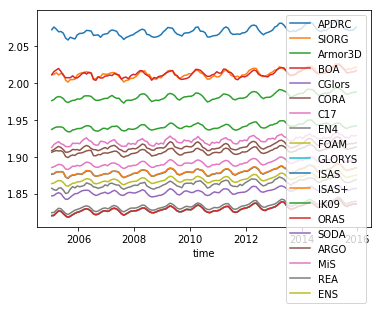

In [13]:
ydata=list(glb)
lb=list(fname)
sl.plot_ts(tdec,ydata,label=lb)

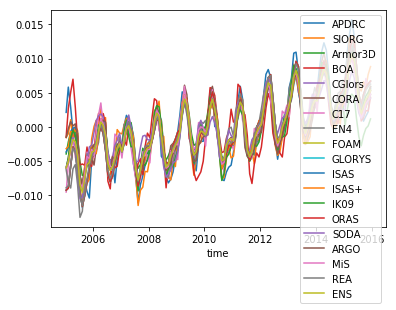

In [14]:
ydata=list(glbmu)
lb=list(fname)
sl.plot_ts(tdec,ydata,label=lb)

## 1993-2017

In [15]:
ds=xr.open_dataset('/Users/ccamargo/Desktop/paper1/steric/data/final/1993-2017/alldatasets_13_regional.nc')
ds

lat=np.array(ds.lat)
lon=np.array(ds.lon)
tdec=np.array(ds.tdec)
fname=np.array(ds.fname)
time=np.array(ds.time)
glb=np.zeros((len(fname),len(tdec)))
glbmu=np.zeros((len(fname),len(tdec)))

for i,f in enumerate(fname):
    data=np.array(ds.data[i,:,:,:])
    mu,glb[i,:]=sl.reg_to_glb(data,lat,lon,tdec)
    
    data=np.array(ds.datamu[i,:,:,:])
    mu,glbmu[i,:]=sl.reg_to_glb(data,lat,lon,tdec)
    
# Create final dataset
da=xr.Dataset(data_vars={'glb':(('fname','time'),glb),
                        'glbmu':(('fname','time'),glbmu)},
                         coords={'fname':fname,
                                 'time':time,
                                 'tdec':tdec})

# Add attributes
da.attrs['name'] = 'Global mean Steric SL (m) at surface in relation to 2000m'  
da.attrs['glb_longname'] = 'Original data'
da.attrs['glbmu_longname'] = 'We removed the mean of each dataset, so that they were all around zero.'

da.attrs['group_means']='ENS and Group means (MiS, REA) were computed by taking the mean over the name axis of data and datamu' 
da.attrs['MiS']='Armor3D, CORA, C17, IK09, EN4'
da.attrs['REA']='CGlors, GLORYS, FOAM, ORAS, SODA'

#Save netcdf
da.to_netcdf('/Users/ccamargo/Desktop/paper1/steric/data/final/1993-2017/alldatasets_13_global.nc')

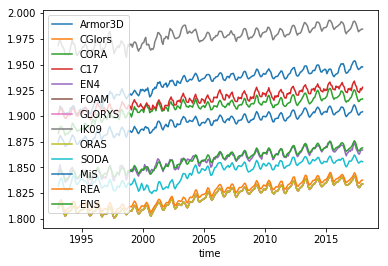

In [16]:
ydata=list(glb)
lb=list(fname)
sl.plot_ts(tdec,ydata,label=lb)

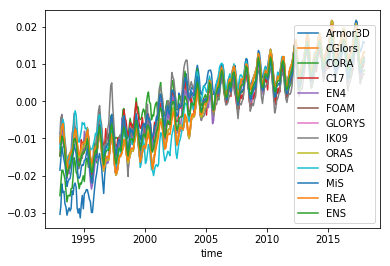

In [17]:
ydata=list(glbmu)
lb=list(fname)
sl.plot_ts(tdec,ydata,label=lb)